In [1]:
import matplotlib.pyplot as plt
import torch
import ehc_sn as ehc

In [2]:
from ipywidgets import interact, IntSlider, FloatSlider
from functools import partial

IntSlider = partial(IntSlider, continuous_update=False)
FloatSlider = partial(FloatSlider, continuous_update=False)

In [3]:
class SNN(ehc.Network):
    we_acc: list[torch.Tensor] = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xe, xi = self.spikes  # Collect the spikes from the previous time step
        xe = self.layers["excitatory"](torch.concatenate([x, xe, -xi]))
        xi = self.layers["inhibitory"](torch.concatenate([xe, -xi]))
        self.we_acc.append(self.layers["excitatory"].w.clone())
        return xe

In [4]:
import tomllib as toml

with open("configurations/experiment_20250326.toml", "rb") as f:
    data = toml.load(f)

In [5]:
def plot_raster(spikes, title):
    for neuron_idx in range(spikes.shape[1]):
        spike_times = torch.nonzero(spikes[:, neuron_idx]).squeeze()
        plt.scatter(spike_times, neuron_idx * torch.ones_like(spike_times), s=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Neuron Index")
    plt.xlim(0, spikes.shape[0])
    plt.ylim(0, spikes.shape[1])
    plt.show()

In [6]:
def plot_output(firing_rates, title):
    plt.plot(firing_rates)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Firing Rate")
    plt.ylim(0, 0.200)  # 0.2 == 1/rho_reset
    plt.show()

In [7]:
model = ehc.EHCModel(SNN(p=ehc.NetworkParameters.model_validate(data)))
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): EHCModel(
    (encoder): PoissonEncoderStep()
    (network): SNN(
      (layers): ModuleDict(
        (excitatory): STDPLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(0.2000, device='cuda:0'), tau_mem_inv=tensor(0.5000, device='cuda:0'), v_leak=tensor(-60., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
        (inhibitory): STDPLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(0.1000, device='cuda:0'), tau_mem_inv=tensor(0.5000, device='cuda:0'), v_leak=tensor(-50., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      )
    )
    (decoder): SumDecoder()
  )
)

In [8]:
exc_current = torch.zeros(4000, 100).to(ehc.device)
exc_current[:20, :20] = 0.1
model.network.reset()
firing_rates = []
spikes = []
with torch.no_grad():
    for x in exc_current:
        r, s = model(x)
        firing_rates.append(r)
        spikes.append(s)
firing_rates = torch.stack(firing_rates)
spikes = torch.stack(spikes)

W0326 22:30:25.842000 3846 site-packages/torch/_dynamo/convert_frame.py:906] [0/8] torch._dynamo hit config.cache_size_limit (8)
W0326 22:30:25.842000 3846 site-packages/torch/_dynamo/convert_frame.py:906] [0/8]    function: 'forward' (/home/borja/projects/spatial-navigation/ehc-sn/src/ehc_sn/model.py:134)
W0326 22:30:25.842000 3846 site-packages/torch/_dynamo/convert_frame.py:906] [0/8]    last reason: 0/0: tensor 'L['self']._modules['network']._modules['layers']._modules['excitatory'].nodes[0]' requires_grad mismatch. expected requires_grad=1
W0326 22:30:25.842000 3846 site-packages/torch/_dynamo/convert_frame.py:906] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0326 22:30:25.842000 3846 site-packages/torch/_dynamo/convert_frame.py:906] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


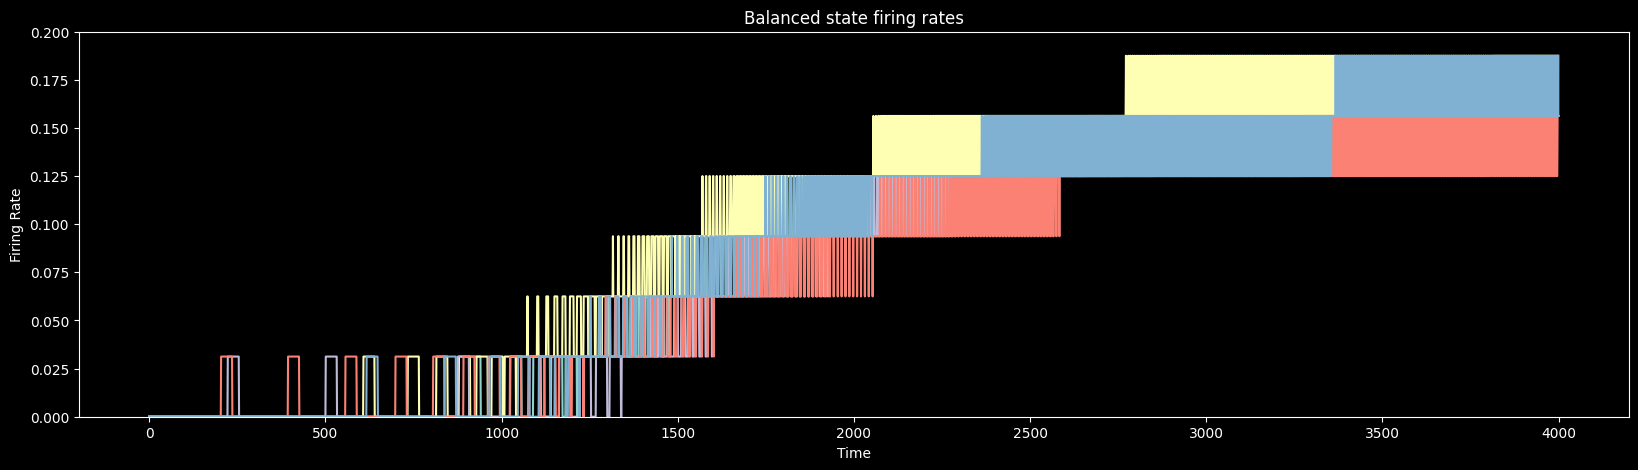

In [9]:
plt.figure(figsize=(20, 5))
plot_output(firing_rates[:, :5].to("cpu"), "Balanced state firing rates")
plt.show()

In [10]:
def plot_weights(wie_acc, title):
    plt.figure(figsize=(10, 5))
    plt.plot(wie_acc.to("cpu").numpy())
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Synaptic Weight")
    plt.show()

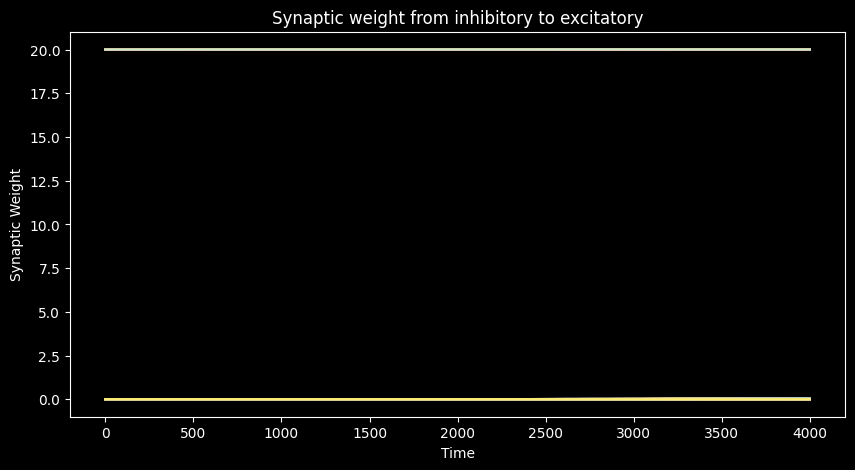

In [11]:
we_acc = torch.stack([x[:20] for x in model.network.we_acc])
plot_weights(we_acc[:, 1], "Synaptic weight from inhibitory to excitatory")